# Using SVMs to classify mileage in `Auto` dataset

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Preparing the data

In [22]:
auto = pd.read_csv('../../datasets/Auto.csv', index_col=0)
auto.reset_index(inplace=True, drop=True)
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [23]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null int64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(3), int64(5), object(1)
memory usage: 27.6+ KB


## a. Create high/low mileage variable and preprocess

In [24]:
# add mileage binary variable
auto['high_mpg'] = (auto['mpg'] > auto['mpg'].median()).astype(int)

auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,high_mpg
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0


We found [this article](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) helpful. We'll scale the data to the interval [0, 1].

In [25]:
df = auto.drop(columns=['name'])
df = (df - df.min())/(df.max() - df.min())

## b. Linear SVC

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# rough tuning param
param = {'C': np.logspace(0, 9, 10)}
linear_svc = SVC(kernel='linear')
linear_svc_search = GridSearchCV(estimator=linear_svc,
                                 param_grid=param,
                                 cv=7,
                                 scoring='accuracy')
X, Y = df.drop(columns=['high_mpg']), auto['high_mpg']
%timeit -n1 -r1 linear_svc_search.fit(X, Y)

804 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [34]:
linear_svc_search_df = pd.DataFrame(linear_svc_search.cv_results_)
linear_svc_search_df[['param_C', 'mean_test_score']]

,param_C,mean_test_score
0,1,0.908163
1,10,0.969388
2,100,0.984694
3,1000,0.997449
4,10000,0.997449
5,100000,0.997449
6,1e+06,0.997449
7,1e+07,0.997449
8,1e+08,0.997449
9,1e+09,0.997449


In [35]:
linear_svc_search.best_params_

{'C': 1000.0}

In [38]:
linear_svc_search.best_score_

0.9974489795918368

In [36]:
# fine tuning param
param = {'C': np.linspace(500, 1500, 1000)}
linear_svc = SVC(kernel='linear')
linear_svc_search = GridSearchCV(estimator=linear_svc,
                                 param_grid=param,
                                 cv=7,
                                 scoring='accuracy')
%timeit -n1 -r1 linear_svc_search.fit(X, Y)

54.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [39]:
linear_svc_search.best_params_

{'C': 696.1961961961962}

In [40]:
linear_svc_search.best_score_

0.9974489795918368

## c. Nonlinear SVCs

### Polynomial SVC

In [43]:
# rough param tuning
params = {'C': np.logspace(-4, 4, 9),
          'gamma': np.logspace(-4, 4, 9),
          'degree': [2, 3]}
poly_svc = SVC(kernel='poly')
poly_svc_search = GridSearchCV(estimator=poly_svc,
                                 param_grid=params,
                                 cv=7,
                                 scoring='accuracy')
%timeit -n1 -r1 poly_svc_search.fit(X, Y)

8.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [44]:
poly_svc_search.best_params_

{'C': 0.001, 'degree': 2, 'gamma': 100.0}

In [45]:
poly_svc_search.best_score_

0.9617346938775511

In [48]:
params = {'C': np.linspace(0.0001, 0.01, 20),
          'gamma': np.linspace(50, 150, 20)}
poly_svc = SVC(kernel='poly', degree=2)
poly_svc_search = GridSearchCV(estimator=poly_svc,
                                 param_grid=params,
                                 cv=7,
                                 scoring='accuracy')
%timeit -n1 -r1 poly_svc_search.fit(X, Y)

19.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [49]:
poly_svc_search.best_params_

{'C': 0.0068736842105263166, 'gamma': 50.0}

In [50]:
poly_svc_search.best_score_

0.9668367346938775

### Radial SVC

In [54]:
# rough param tuning
params = {'C': np.logspace(-4, 4, 9),
          'gamma': np.logspace(-4, 4, 9)}
radial_svc = SVC(kernel='rbf')
radial_svc_search = GridSearchCV(estimator=radial_svc,
                                 param_grid=params,
                                 cv=7,
                                 scoring='accuracy')
%timeit -n1 -r1 radial_svc_search.fit(X, Y)

5.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [55]:
radial_svc_search.best_params_

{'C': 1000.0, 'gamma': 0.01}

In [56]:
radial_svc_search.best_score_

0.9795918367346939

In [57]:
params = {'C': np.logspace(4, 9, 5),
          'gamma': np.linspace(0.001, 0.1, 100)}
radial_svc = SVC(kernel='rbf')
radial_svc_search = GridSearchCV(estimator=radial_svc,
                                 param_grid=params,
                                 cv=7,
                                 scoring='accuracy')
%timeit -n1 -r1 radial_svc_search.fit(X, Y)

20.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [58]:
radial_svc_search.best_params_

{'C': 177827.94100389228, 'gamma': 0.002}

In [59]:
radial_svc_search.best_score_

0.9974489795918368

## d. CV error plots

### Linear SVC

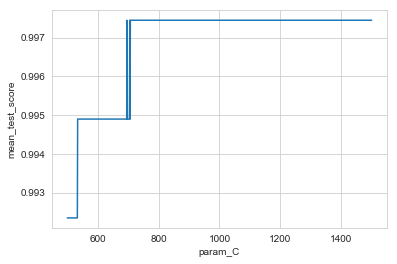

In [63]:
linear_svc_df = pd.DataFrame(linear_svc_search.cv_results_)
sns.lineplot(x=linear_svc_df['param_C'], y=linear_svc_df['mean_test_score'])

### Quadratic SVC

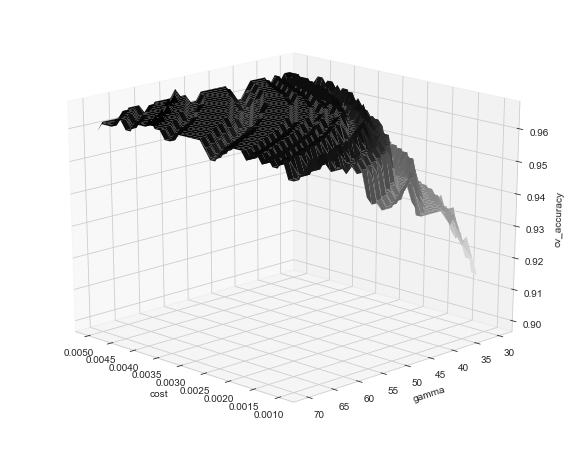

In [95]:
from mpl_toolkits import mplot3d

poly_svc_df = pd.DataFrame(poly_svc_search.cv_results_)

cost, gamma = poly_svc_df['param_C'].unique(), poly_svc_df['param_gamma'].unique()

X, Y = np.meshgrid(cost, gamma)
Z = scores = poly_svc_df['mean_test_score'].values.reshape(len(cost), len(gamma))

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='Greys', edgecolor='none')
ax.set_xlabel('cost')
ax.set_ylabel('gamma')
ax.set_zlabel('cv_accuracy');
ax.view_init(20, 135)

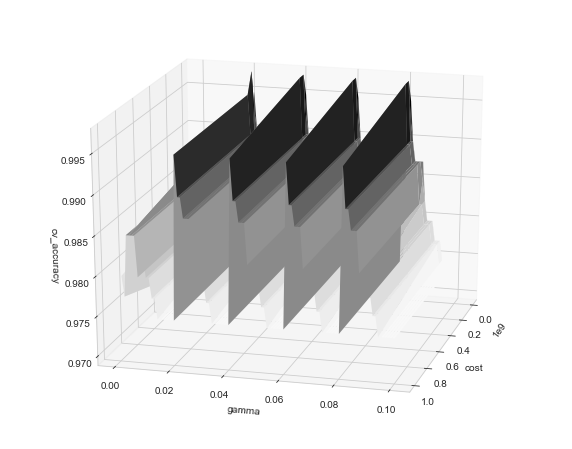

In [108]:
radial_svc_df = pd.DataFrame(radial_svc_search.cv_results_)

cost, gamma = radial_svc_df['param_C'].unique(), radial_svc_df['param_gamma'].unique()

X, Y = np.meshgrid(cost, gamma)
Z = scores = radial_svc_df['mean_test_score'].values.reshape(len(gamma), len(cost))

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='Greys', edgecolor='none')
ax.set_xlabel('cost')
ax.set_ylabel('gamma')
ax.set_zlabel('cv_accuracy');
ax.view_init(20, 15)